In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict

In [2]:
from ranking_funcs import get_probs,get_prob_backdoor,filter_prob_df_grouped,read_data,get_ranking_query_prob_grouped,get_stable_ranking_opt,get_ranking_query,get_ranking_query_prob,get_test_revert_ranking_rec,get_new_G,filter_prob_df,calc_prob,base_line

In [3]:
df=read_data('German.csv')

installment_plans
number_of_credits
employment
housing
credit_history
skill_level


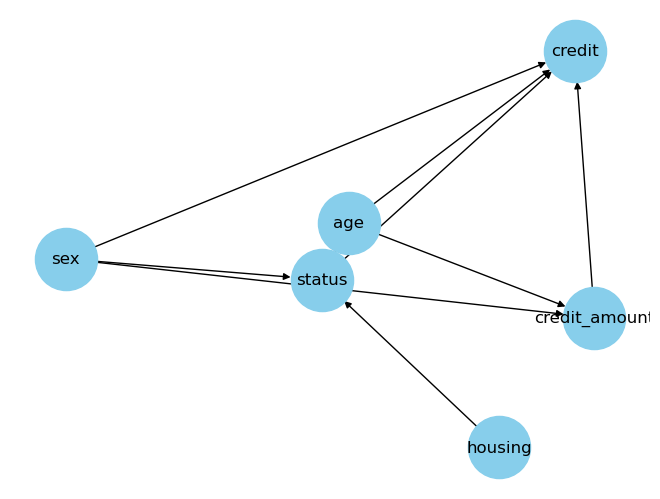

In [4]:
G = nx.DiGraph()


nodes = ['sex', 'status', 'credit_amount', 'credit', 'age', 'housing']
G.add_nodes_from(nodes)

G.add_edges_from([('sex', 'status'), ('sex', 'credit_amount'), ('sex', 'credit'),
                  ('housing', 'status'), ('age', 'status'), 
                  ('age', 'credit'), ('age', 'credit_amount'),('credit_amount', 'credit'),('status', 'credit')])


pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue")
plt.show()

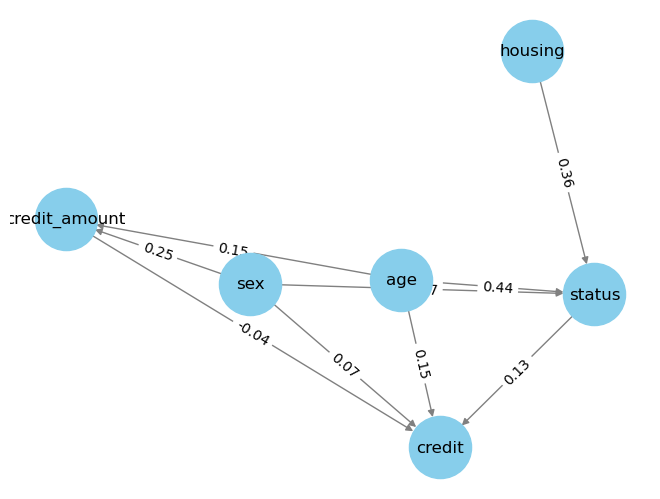

In [5]:
new_G=get_new_G(G,df)
pos = nx.spring_layout(new_G)
nx.draw(new_G, pos, with_labels=True, node_size=2000, node_color="skyblue", 
        edge_color="grey", width=1)

edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in new_G.edges(data=True)}
nx.draw_networkx_edge_labels(new_G, pos, edge_labels=edge_labels)
plt.show()

In [6]:
ranks=get_ranking_query(new_G, df, 5, {'housing':1}, 'credit_amount',{'age':1},'fix')
ranks

month  age    credit  installment_plans  credit_amount  number_of_credits  \
5       3  1.0  1.046003                  1              3                  0   
1       3  0.0  0.000000                  1              3                  0   
7       3  1.0  1.046003                  1              3                  0   
3       3  1.0  1.046003                  1              3                  0   
17      3  0.0  1.000000                  0              3                  1   

    employment  purpose  sex  housing  ...  credit_history  property  \
5          2.0      5.0  1.0        1  ...             2.0       3.0   
1          2.0      4.0  0.0        1  ...             2.0       0.0   
7          2.0      2.0  1.0        1  ...             2.0       2.0   
3          3.0      3.0  1.0        1  ...             2.0       1.0   
17         0.0      5.0  1.0        1  ...             0.0       2.0   

    foreign_worker  investment_as_income_percentage  people_liable_for  \
5              0.0                              2.0                2.0   
1              0.0                              2.0                1.0   
7              0.0                              2.0                1.0   
3              0.0                              2.0                2.0   
17             0.0                              2.0                1.0   

    telephone  other_debtors    status  skill_level  savings  
5         1.0              0  3.359667          0.0        2  
1         0.0              0  1.000000          2.0        0  
7         1.0              0  1.359667          3.0        0  
3         0.0              1  0.359667          2.0        0  
17        0.0              0  0.000000          2.0        2  

[5 rows x 21 columns]

### Simulating the ranking probility

In [7]:
base_line(df,5)

1.0100653517088042e-15

#### Backdoor adjustment probs

In [8]:
get_prob_backdoor(get_ranking_query(new_G, df, len(df), {'housing':1}, 'credit_amount',{'age':1},'fix'),new_G,'credit_amount')

P(credit_amount = 0|status = 0.0 & ['sex', 'age', 'housing']: 0.36350293299467823)
P(credit_amount = 0|status = 1.0 & ['sex', 'age', 'housing']: 0.33000241545893727)
P(credit_amount = 0|status = 3.0 & ['sex', 'age', 'housing']: 0.2945486432099463)
P(credit_amount = 0|status = 0.3596669126378703 & ['sex', 'age', 'housing']: 0.13881847475832437)
P(credit_amount = 0|status = 3.3596669126378704 & ['sex', 'age', 'housing']: 0.20888235294117646)
P(credit_amount = 0|status = 1.3596669126378704 & ['sex', 'age', 'housing']: 0.0774722222222222)
P(credit_amount = 0|status = 2.3596669126378704 & ['sex', 'age', 'housing']: 0.42263888888888884)
P(credit_amount = 0|status = 2.0 & ['sex', 'age', 'housing']: 0.5084166666666666)
P(credit_amount = 3|status = 0.0 & ['sex', 'age', 'housing']: 0.11688479680696662)
P(credit_amount = 3|status = 1.0 & ['sex', 'age', 'housing']: 0.17307487922705317)
P(credit_amount = 3|status = 3.0 & ['sex', 'age', 'housing']: 0.13903743524153422)
P(credit_amount = 3|status = 0

In [9]:
ranks_prob=get_ranking_query_prob(new_G, df, 5, {'housing':1}, 'credit_amount',{'age':1},'fix')
ranks_prob

row_index         1         2         3         4         5
0            0  0.000000  0.000000  0.000000  0.000000  0.000000
1            1  0.005952  0.005952  0.005952  0.005952  0.005952
2            2  0.000000  0.000000  0.000000  0.000000  0.000000
3            3  0.005952  0.005952  0.005952  0.005952  0.005952
4            4  0.000000  0.000000  0.000000  0.000000  0.000000
..         ...       ...       ...       ...       ...       ...
995        995  0.000000  0.000000  0.000000  0.000000  0.000000
996        996  0.000000  0.000000  0.000000  0.000000  0.000000
997        997  0.000000  0.000000  0.000000  0.000000  0.000000
998        998  0.000000  0.000000  0.000000  0.000000  0.000000
999        999  0.000000  0.000000  0.000000  0.000000  0.000000

[1000 rows x 6 columns]

In [10]:
ranks_prob_filtered=filter_prob_df(ranks_prob)
ranks_prob_filtered

row_index         1         2         3         4         5
1            1  0.005952  0.005952  0.005952  0.005952  0.005952
3            3  0.005952  0.005952  0.005952  0.005952  0.005952
5            5  0.005952  0.005952  0.005952  0.005952  0.005952
7            7  0.005952  0.005952  0.005952  0.005952  0.005952
17          17  0.005952  0.005952  0.005952  0.005952  0.005952
..         ...       ...       ...       ...       ...       ...
973        973  0.005952  0.005952  0.005952  0.005952  0.005952
980        980  0.005952  0.005952  0.005952  0.005952  0.005952
983        983  0.005952  0.005952  0.005952  0.005952  0.005952
986        986  0.005952  0.005952  0.005952  0.005952  0.005952
988        988  0.005952  0.005952  0.005952  0.005952  0.005952

[168 rows x 6 columns]

In [11]:
get_probs(ranks_prob,[1, 3, 5, 7, 17])

7.934843523730395e-12

### Update housing to divided by 2 for age=1 to rank the credit_amount

In [14]:
ranks_prob_add=get_ranking_query(new_G, df, 5, {'housing':2}, 'credit_amount',{'age':1},'add')
ranks_prob_add

month  age    credit  installment_plans  credit_amount  number_of_credits  \
5       3  1.0  1.092007                  1              3                  0   
1       3  0.0  0.000000                  1              3                  0   
7       3  1.0  1.092007                  1              3                  0   
3       3  1.0  1.092007                  1              3                  0   
17      3  0.0  1.000000                  0              3                  1   

    employment  purpose  sex  housing  ...  credit_history  property  \
5          2.0      5.0  1.0        2  ...             2.0       3.0   
1          2.0      4.0  0.0        1  ...             2.0       0.0   
7          2.0      2.0  1.0        2  ...             2.0       2.0   
3          3.0      3.0  1.0        2  ...             2.0       1.0   
17         0.0      5.0  1.0        1  ...             0.0       2.0   

    foreign_worker  investment_as_income_percentage  people_liable_for  \
5              0.0                              2.0                2.0   
1              0.0                              2.0                1.0   
7              0.0                              2.0                1.0   
3              0.0                              2.0                2.0   
17             0.0                              2.0                1.0   

    telephone  other_debtors    status  skill_level  savings  
5         1.0              0  3.719334          0.0        2  
1         0.0              0  1.000000          2.0        0  
7         1.0              0  1.719334          3.0        0  
3         0.0              1  0.719334          2.0        0  
17        0.0              0  0.000000          2.0        2  

[5 rows x 21 columns]

In [15]:
ranks_prob_add=get_stable_ranking_opt(new_G, df, 5, {'housing':2}, 'credit_amount',{'age':1},1000,'add')
ranks_prob_add

[[None, None], [None, None]]